# Предсказательные модели для Dota 2

Проект разработки сервиса, который по ID матча выдает вероятность победы той или иной команды в Dota 2, а также строит различные сегментационные карты (хитмапы) по результатам игры.

**Участники:**
* Боева Полина Викторовна — @Boeva_pv, PolinaBoeva
* Бородачев Сергей Игоревич — @RaiFox, Rai-Fox
* Герилович Илья Павлович — @mrbrainers, ilyager99
* Чаплыгина Арина Сергеевна — @chaarse, chaarse

**Куратор:** Макарова Мария - @mariagolddd

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

## Шаг 1. Сбор данных

In [2]:
match = {}
for i in range(1, 10):
    key = f'm{i}'
    file_path = f'/kaggle/input/dota-2-pro-league-matches-2023/20240{i}/main_metadata.csv'
    match[key] = pd.read_csv(file_path)

key = 'd10'
file_path = '/kaggle/input/dota-2-pro-league-matches-2023/202410/main_metadata.csv'
match[key] = pd.read_csv(file_path)


players = {}
for i in range(1, 10):
    key = f'p{i}'
    file_path = f'/kaggle/input/dota-2-pro-league-matches-2023/20240{i}/players.csv'
    players[key] = pd.read_csv(file_path, dtype='str')

key = 'd10'
file_path = '/kaggle/input/dota-2-pro-league-matches-2023/202410/players.csv'
players[key] = pd.read_csv(file_path)

In [3]:
match_df = pd.concat(match.values(), ignore_index=True)
players_df = pd.concat(players.values(), ignore_index=True)

In [4]:
match_df.drop(columns=['Unnamed: 0'], inplace=True)
players_df.drop(columns=['Unnamed: 0'], inplace=True)

In [5]:
match_df.head()

,match_id,barracks_status_dire,barracks_status_radiant,cluster,dire_score,duration,engine,first_blood_time,game_mode,human_players,...,radiant_team_id,pre_game_duration,flags,radiant_logo,radiant_team_complete,dire_logo,dire_team_complete,radiant_captain,dire_captain,average_rank
0,7515635423,'00110100','00111111',274,26,1926,1,140,2,10,...,9048057.0,90.0,5.0,2.041868e+18,1.0,1.908989e+18,1.0,1.770622e+08,1.773383e+08,NaN
1,7515660161,'00111111','00001111',273,43,1731,1,121,2,10,...,8850100.0,90.0,5.0,1.908989e+18,1.0,2.041868e+18,1.0,8.408596e+08,2.942451e+08,NaN
2,7515737711,'00111101','00111111',271,25,2056,1,84,2,10,...,8893825.0,90.0,5.0,2.001336e+18,0.0,2.152217e+18,0.0,1.459124e+09,1.459382e+09,NaN
3,7515745579,'00110011','00111111',272,31,2221,1,28,2,10,...,8629324.0,90.0,5.0,2.017089e+18,1.0,2.036224e+18,1.0,1.173255e+09,9.486598e+08,NaN
4,7515769503,'00111111','00000000',153,21,1998,1,264,2,10,...,8736661.0,90.0,1.0,1.899975e+18,0.0,1.831290e+18,0.0,1.363522e+08,1.542238e+08,NaN


In [6]:
players_df.head()

,match_id,player_slot,ability_targets,ability_upgrades_arr,ability_uses,account_id,actions,additional_units,assists,backpack_0,...,purchase_rapier,observers_placed,healing,team_number,team_slot,aghanims_scepter,aghanims_shard,moonshard,hero_variant,neutral_tokens_log
0,7515635423,0,{'earth_spirit_boulder_smash': {'npc_dota_hero...,"[5608, 5609, 5608, 5609, 5608, 5612, 5608, 560...","{'seasonal_party_hat': 1, 'earth_spirit_stone_...",177062248.0,"{'1': 7175, '2': 13, '3': 15, '4': 1733, '5': ...",NaN,21.0,0.0,...,NaN,0.0,"{'npc_dota_hero_earth_spirit': 2641, 'npc_dota...",0.0,0.0,0.0,0.0,0.0,NaN,NaN
1,7515635423,1,{'morphling_adaptive_strike_agi': {'npc_dota_h...,"[5055, 5053, 5053, 5052, 5053, 5057, 5053, 505...","{'seasonal_party_hat': 1, 'morphling_morph_agi...",164322994.0,"{'1': 7336, '2': 10, '3': 49, '4': 1017, '5': ...",NaN,6.0,16.0,...,NaN,0.0,{'npc_dota_hero_morphling': 3227},0.0,1.0,0.0,0.0,0.0,NaN,NaN
2,7515635423,2,{'shadow_demon_disruption': {'npc_dota_hero_lu...,"[5421, 5423, 5423, 5421, 5423, 5425, 5423, 542...","{'ability_lamp_use': 3, 'shadow_demon_shadow_p...",294245092.0,"{'1': 5860, '2': 64, '3': 25, '4': 618, '5': 1...",NaN,18.0,0.0,...,NaN,4.0,"{'npc_dota_hero_shadow_demon': 1156, 'npc_dota...",0.0,2.0,0.0,1.0,0.0,NaN,NaN
3,7515635423,3,{'treant_leech_seed': {'npc_dota_hero_lion': 1...,"[5435, 338, 5435, 338, 5435, 5437, 5435, 338, ...","{'treant_leech_seed': 34, 'treant_natures_gras...",154357932.0,"{'1': 8202, '2': 121, '3': 14, '4': 458, '5': ...",NaN,19.0,16.0,...,NaN,7.0,"{'npc_dota_hero_treant': 6910, 'npc_dota_hero_...",0.0,3.0,0.0,1.0,0.0,NaN,NaN
4,7515635423,4,{},"[5062, 5059, 5062, 5059, 5059, 5062, 5059, 506...","{'ability_lamp_use': 2, 'nevermore_shadowraze2...",279486190.0,"{'1': 4417, '2': 13, '4': 2226, '5': 11, '6': ...",NaN,4.0,0.0,...,NaN,2.0,{'npc_dota_hero_nevermore': 1462},0.0,4.0,0.0,0.0,0.0,NaN,NaN


## Шаг 2. Разведочный анализ данных

### Датасет *match_df*

In [7]:
match_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24704 entries, 0 to 24703
Data columns (total 42 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   match_id                 24704 non-null  int64  
 1   barracks_status_dire     24704 non-null  object 
 2   barracks_status_radiant  24704 non-null  object 
 3   cluster                  24704 non-null  int64  
 4   dire_score               24704 non-null  int64  
 5   duration                 24704 non-null  int64  
 6   engine                   24704 non-null  int64  
 7   first_blood_time         24704 non-null  int64  
 8   game_mode                24704 non-null  int64  
 9   human_players            24704 non-null  int64  
 10  leagueid                 24704 non-null  int64  
 11  lobby_type               24704 non-null  int64  
 12  match_seq_num            24704 non-null  int64  
 13  negative_votes           0 non-null      float64
 14  positive_votes        

In [8]:
match_df.dropna(axis=1, how='all', inplace=True)

In [9]:
match_df.isna().sum()

match_id                       0
barracks_status_dire           0
barracks_status_radiant        0
cluster                        0
dire_score                     0
duration                       0
engine                         0
first_blood_time               0
game_mode                      0
human_players                  0
leagueid                       0
lobby_type                     0
match_seq_num                  0
radiant_score                  0
radiant_win                  785
start_date_time                0
tower_status_dire              0
tower_status_radiant           0
version                        0
replay_salt                    0
series_id                   5729
series_type                 5729
patch                          0
region                       555
throw                      12065
loss                       12065
comeback                   12681
stomp                      12681
replay_url                     0
dire_team_id                 997
radiant_te

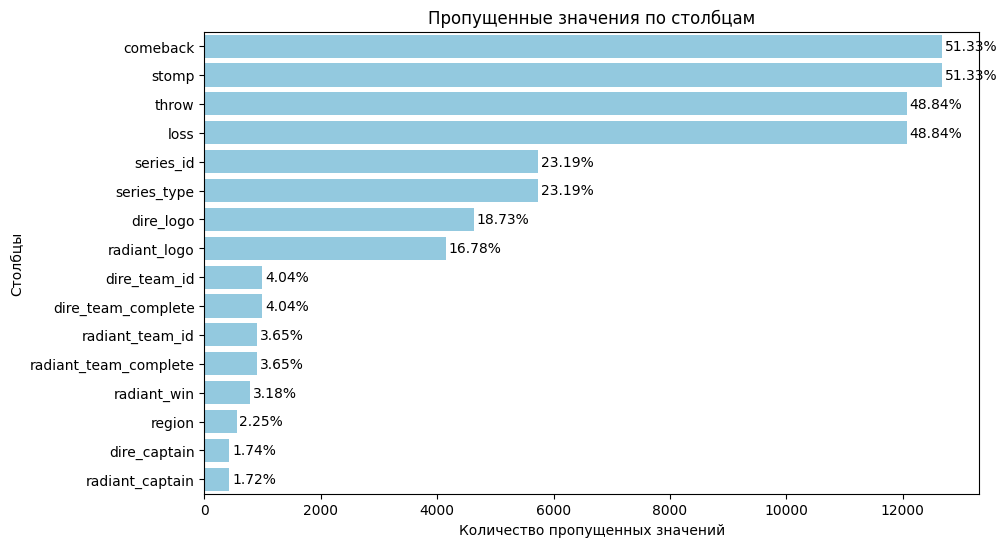

In [10]:
n_rows = len(match_df)
cols_with_na = match_df.columns[match_df.isna().any()] # столбцы с пропущенными значениями

plt.figure(figsize=(10, 6))
sorted_cols = match_df.isna().sum()[cols_with_na].sort_values(ascending=False).index

ax = sns.barplot(y=sorted_cols, x=match_df.isna().sum()[sorted_cols], orient='h', color="skyblue")

for i, v in enumerate(match_df.isna().sum()[sorted_cols]):
    ax.text(v + 50, i, f"{v / n_rows:.2%}", va='center', fontsize=10)

plt.xlabel('Количество пропущенных значений')
plt.ylabel('Столбцы')
plt.title('Пропущенные значения по столбцам')
plt.show()

### Обработка пропусков

In [11]:
# удалим строки с пропусками, которые составляют менее 5%
threshold = 0.05
index = match_df.isna().mean() < threshold
columns_to_drop = index[index == True].index

match_df = match_df.dropna(subset=columns_to_drop)

In [12]:
# столбцы, в которых содержится более 5% пропусков
match_df[['series_id', 'series_type', 'throw', 'loss', 'comeback', 'stomp', 'radiant_logo', 'dire_logo']]

,series_id,series_type,throw,loss,comeback,stomp,radiant_logo,dire_logo
0,NaN,NaN,571.0,8188.0,NaN,NaN,2.041868e+18,1.908989e+18
1,NaN,NaN,NaN,NaN,3347.0,22431.0,1.908989e+18,2.041868e+18
2,838321.0,1.0,348.0,7541.0,NaN,NaN,2.001336e+18,2.152217e+18
3,838323.0,1.0,2602.0,11185.0,NaN,NaN,2.017089e+18,2.036224e+18
4,838324.0,1.0,NaN,NaN,1361.0,29785.0,1.899975e+18,1.831290e+18
...,...,...,...,...,...,...,...,...
24699,921063.0,1.0,NaN,NaN,0.0,26663.0,2.460727e+18,1.914618e+18
24700,921063.0,1.0,2522.0,14885.0,NaN,NaN,1.914618e+18,2.460727e+18
24701,921081.0,1.0,NaN,NaN,463.0,20062.0,2.045233e+18,2.431454e+18
24702,921081.0,1.0,NaN,NaN,6576.0,9270.0,2.431454e+18,2.045233e+18


Описание столбцов с пропусками:

* series_id (идентификатор серии матчей): возможно, информация о серии матчей не всегда фиксировалась или была доступна только для части матчей. Пропущенные значения можно заменить на модальное значение.
* series_type (тип серии матча): аналогично series_id
* throw (признак того, что одна из команд сознательно проиграла матч): по умолчанию можно считать, что если информация о бросании отсутствует, значит, команда не бросала игру. Никак не заменяем.
* loss (признак поражения одной из команд): аналогично throw.Никак не заменяем.
* comeback (признак камбека в матче): если информация о камбеке отсутствует, можно считать его не произошедшим и никак не изменять.
* stomp (признак доминирования одной из команд над другой): аналогично comeback. Так же, как и для предыдущих полей, можно никак не изменять.
* radiant_logo (логотип команды Radiant): логотип мог быть недоступен или не загружен на момент сохранения данных. Никак не заменяем.
* dire_logo (логотип команды Dire): причины те же, что и для radiant_logo. Никак не заменяем.

In [13]:
fill_values = {
    'series_id': match_df['series_id'].mode()[0],
    'series_type': match_df['series_type'].mode()[0]
}

match_df.fillna(fill_values, inplace=True)
match_df.isna().sum()

match_id                       0
barracks_status_dire           0
barracks_status_radiant        0
cluster                        0
dire_score                     0
duration                       0
engine                         0
first_blood_time               0
game_mode                      0
human_players                  0
leagueid                       0
lobby_type                     0
match_seq_num                  0
radiant_score                  0
radiant_win                    0
start_date_time                0
tower_status_dire              0
tower_status_radiant           0
version                        0
replay_salt                    0
series_id                      0
series_type                    0
patch                          0
region                         0
throw                      10902
loss                       10902
comeback                   11094
stomp                      11094
replay_url                     0
dire_team_id                   0
radiant_te

### Расчет основных статистик

In [14]:
match_df.describe(include='all')

,match_id,barracks_status_dire,barracks_status_radiant,cluster,dire_score,duration,engine,first_blood_time,game_mode,human_players,...,dire_team_id,radiant_team_id,pre_game_duration,flags,radiant_logo,radiant_team_complete,dire_logo,dire_team_complete,radiant_captain,dire_captain
count,2.199500e+04,21995,21995,21995.000000,21995.000000,21995.000000,21995.0,21995.000000,21995.000000,21995.000000,...,2.199500e+04,2.199500e+04,21995.0,21995.000000,1.890600e+04,21995.000000,1.916800e+04,21995.000000,2.199500e+04,2.199500e+04
unique,NaN,51,52,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,'00111111','00111111',NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,11055,11167,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,7.769170e+09,NaN,NaN,238.217868,28.825188,1996.168811,1.0,126.099386,2.029279,9.999773,...,8.571129e+06,8.595441e+06,90.0,3.519027,2.278090e+18,0.495294,2.284032e+18,0.497931,6.884535e+08,6.960917e+08
std,1.439717e+08,NaN,NaN,52.943332,12.580393,563.734266,0.0,117.416147,0.639588,0.020227,...,1.808271e+06,1.757884e+06,0.0,1.803031,7.508606e+17,0.499989,7.435051e+17,0.500007,5.945779e+08,5.956410e+08
min,7.515635e+09,NaN,NaN,121.000000,0.000000,428.000000,1.0,0.000000,2.000000,8.000000,...,5.000000e+00,5.000000e+00,90.0,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,8.487180e+05,1.539190e+06
25%,7.645801e+09,NaN,NaN,184.000000,19.000000,1618.000000,1.0,18.000000,2.000000,10.000000,...,8.629318e+06,8.629318e+06,90.0,4.000000,2.009201e+18,0.000000,2.017089e+18,0.000000,1.550564e+08,1.553325e+08
50%,7.772006e+09,NaN,NaN,271.000000,29.000000,1894.000000,1.0,109.000000,2.000000,10.000000,...,9.017006e+06,9.011000e+06,90.0,4.000000,2.295212e+18,0.000000,2.295212e+18,0.000000,3.672178e+08,3.693425e+08
75%,7.894896e+09,NaN,NaN,273.000000,37.000000,2272.500000,1.0,189.000000,2.000000,10.000000,...,9.337731e+06,9.344338e+06,90.0,5.000000,2.471990e+18,1.000000,2.470859e+18,1.000000,1.216609e+09,1.220632e+09


### Описательная статистика

In [15]:
num_match_df = match_df[['match_id', 'cluster', 'dire_score', 'duration', 'game_mode', 
                        'human_players', 'leagueid', 'lobby_type', 'match_seq_num', 'radiant_score', 
                        'radiant_win', 'version', 'replay_salt', 'series_id', 'series_type', 
                        'patch', 'region', 'throw', 'loss', 'comeback', 'stomp', 'dire_team_id', 
                        'radiant_team_id', 'pre_game_duration', 'flags', 'radiant_logo', 
                        'radiant_team_complete', 'dire_logo', 'dire_team_complete', 
                        'radiant_captain', 'dire_captain']]
corr_matrix = num_match_df.corr()
corr_matrix

,match_id,cluster,dire_score,duration,game_mode,human_players,leagueid,lobby_type,match_seq_num,radiant_score,...,dire_team_id,radiant_team_id,pre_game_duration,flags,radiant_logo,radiant_team_complete,dire_logo,dire_team_complete,radiant_captain,dire_captain
match_id,1.000000,0.147712,-0.022263,-0.070246,-0.068437,0.015272,0.498648,NaN,0.999948,-0.033672,...,0.023031,0.031183,NaN,0.076805,0.091189,0.092499,0.078673,0.095942,0.069092,0.073972
cluster,0.147712,1.000000,-0.002439,-0.077271,-0.048556,0.023397,0.016877,NaN,0.147765,-0.021329,...,-0.034922,-0.025327,NaN,0.045079,-0.009694,0.313349,0.039606,0.305079,0.196370,0.194440
dire_score,-0.022263,-0.002439,1.000000,0.326693,-0.007987,-0.000692,-0.166592,NaN,-0.022089,0.002232,...,0.067098,0.079777,NaN,-0.161322,0.036454,-0.111206,0.014720,-0.095877,0.153178,0.131361
duration,-0.070246,-0.077271,0.326693,1.000000,0.040134,-0.003828,0.069603,NaN,-0.070523,0.264359,...,-0.069047,-0.067977,NaN,-0.342983,-0.029976,-0.044269,-0.008609,-0.040487,-0.212193,-0.209570
game_mode,-0.068437,-0.048556,-0.007987,0.040134,1.000000,0.000515,-0.029097,NaN,-0.068436,-0.002762,...,0.014915,0.014383,NaN,-0.034154,0.000711,-0.045351,-0.000194,-0.045591,-0.042646,-0.040573
human_players,0.015272,0.023397,-0.000692,-0.003828,0.000515,1.000000,0.004890,NaN,0.015267,0.017190,...,-0.004585,0.006817,NaN,0.011962,0.000578,0.011133,0.000220,0.011192,0.010184,0.010363
leagueid,0.498648,0.016877,-0.166592,0.069603,-0.029097,0.004890,1.000000,NaN,0.498597,-0.165270,...,-0.126487,-0.116381,NaN,0.054324,-0.001902,0.200438,-0.004757,0.207474,-0.289028,-0.284220
lobby_type,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
match_seq_num,0.999948,0.147765,-0.022089,-0.070523,-0.068436,0.015267,0.498597,NaN,1.000000,-0.033591,...,0.022928,0.031188,NaN,0.078689,0.091376,0.092740,0.079038,0.096170,0.069445,0.074415
radiant_score,-0.033672,-0.021329,0.002232,0.264359,-0.002762,0.017190,-0.165270,NaN,-0.033591,1.000000,...,0.090521,0.072606,NaN,-0.155699,0.017517,-0.116648,0.011494,-0.145396,0.121238,0.137795


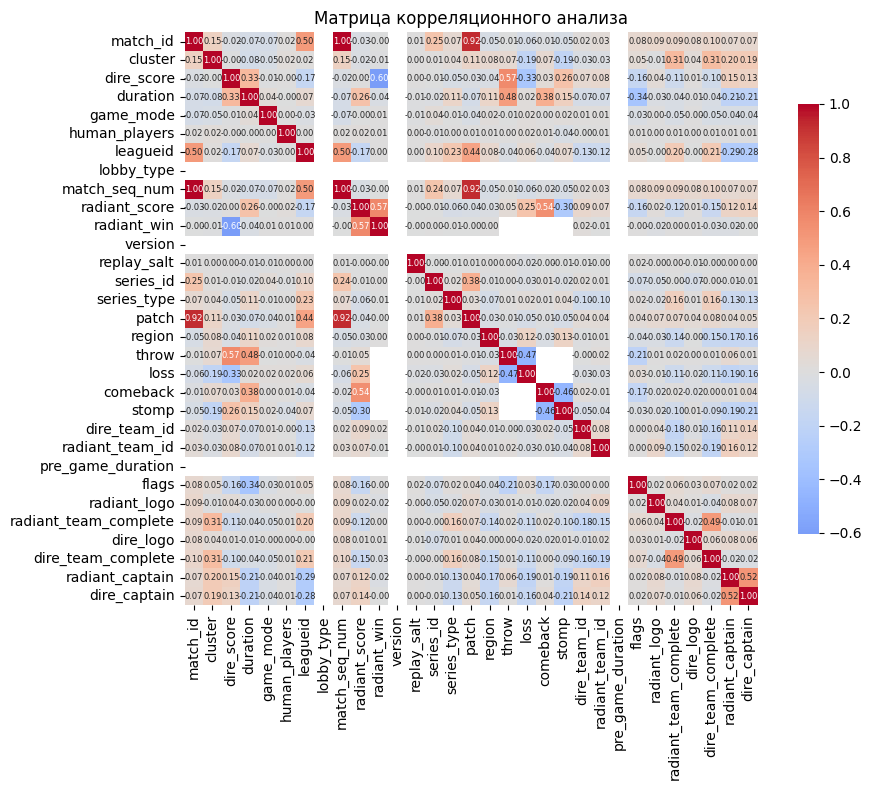

In [16]:
fig, ax = plt.subplots(figsize=(10, 8))
mask = np.zeros_like(corr_matrix, dtype=bool)
mask[np.triu(corr_matrix) != 0] = True
sns.heatmap(data=corr_matrix, annot=True, cmap='coolwarm', center=0, square=True, cbar_kws={"shrink": 0.75}, fmt='.2f', annot_kws={'size': 6})
plt.title('Матрица корреляционного анализа')
plt.tight_layout()
plt.show()

In [17]:
target = 'radiant_win'
correlations = abs(corr_matrix[target])
top_correlations = correlations.sort_values(ascending=False)
top_correlations[:10]

radiant_win           1.000000
dire_score            0.602682
radiant_score         0.574318
duration              0.035975
dire_team_complete    0.027108
radiant_captain       0.021459
radiant_logo          0.019885
dire_team_id          0.018289
cluster               0.011690
radiant_team_id       0.007734
Name: radiant_win, dtype: float64

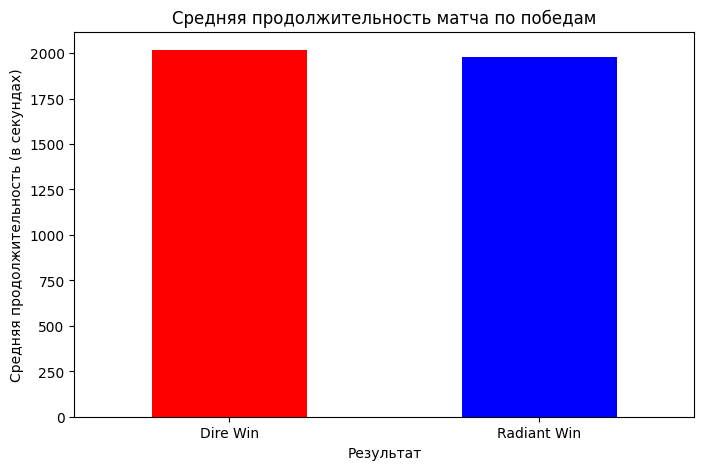

In [18]:
mean_duration = match_df.groupby('radiant_win')['duration'].mean()
mean_duration.plot(kind='bar', color=['red', 'blue'], figsize=(8, 5))
plt.title('Средняя продолжительность матча по победам')
plt.xlabel('Результат')
plt.ylabel('Средняя продолжительность (в секундах)')
plt.xticks([0, 1], ['Dire Win', 'Radiant Win'], rotation=0)
plt.show()

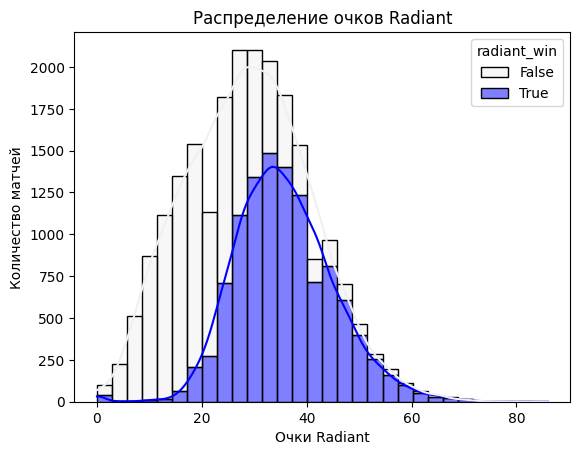

In [19]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

sns.histplot(data=match_df, x='radiant_score', hue='radiant_win', multiple='stack', 
             kde=True, palette='light:b', bins=30)
plt.title('Распределение очков Radiant')
plt.xlabel('Очки Radiant')
plt.ylabel('Количество матчей')
plt.show()

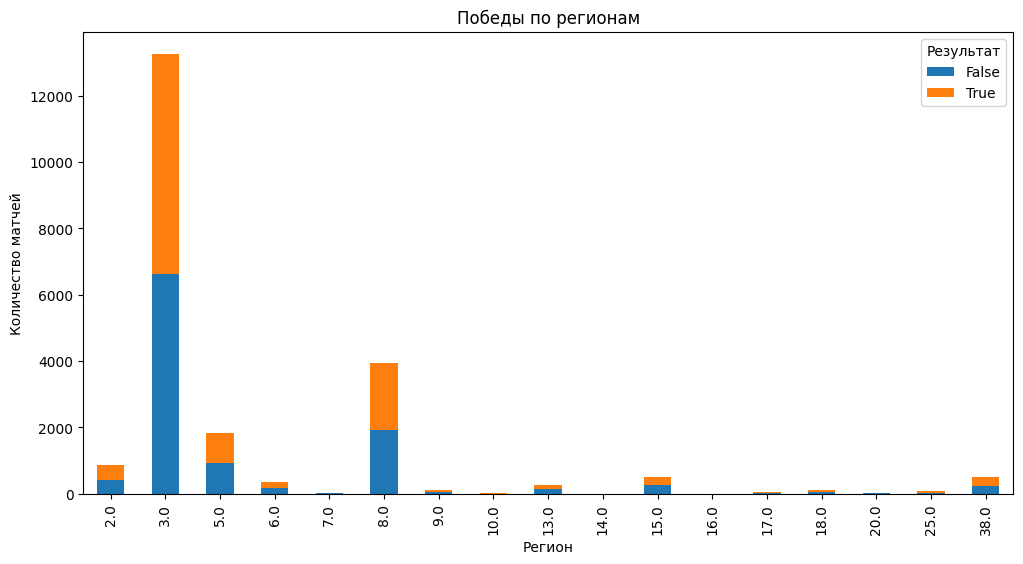

In [20]:
region_wins = match_df.groupby(['region', 'radiant_win']).size().unstack()
region_wins.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Победы по регионам')
plt.xlabel('Регион')
plt.ylabel('Количество матчей')
plt.legend(title='Результат')
plt.show()

### Оставим в датасете только те столбцы, которые могут влиять на результат матча:

In [21]:
match_df = match_df[['match_id', 'barracks_status_dire', 'barracks_status_radiant', 'dire_score',
                     'radiant_score', 'duration', 'first_blood_time', 'game_mode', 'human_players',
                     'lobby_type', 'radiant_win', 'tower_status_dire', 'tower_status_radiant', 
                     'throw', 'loss', 'comeback', 'stomp', 'pre_game_duration']]
match_df.head()

,match_id,barracks_status_dire,barracks_status_radiant,dire_score,radiant_score,duration,first_blood_time,game_mode,human_players,lobby_type,radiant_win,tower_status_dire,tower_status_radiant,throw,loss,comeback,stomp,pre_game_duration
0,7515635423,'00110100','00111111',26,42,1926,140,2,10,1,True,'0000000110000000','0000011110110111',571.0,8188.0,NaN,NaN,90.0
1,7515660161,'00111111','00001111',43,18,1731,121,2,10,1,False,'0000011111110110','0000011000100111',NaN,NaN,3347.0,22431.0,90.0
2,7515737711,'00111101','00111111',25,35,2056,84,2,10,1,True,'0000011100100000','0000011110110111',348.0,7541.0,NaN,NaN,90.0
3,7515745579,'00110011','00111111',31,51,2221,28,2,10,1,True,'0000010110000110','0000011100110100',2602.0,11185.0,NaN,NaN,90.0
4,7515769503,'00111111','00000000',21,11,1998,264,2,10,1,False,'0000011111110110','0000000000000000',NaN,NaN,1361.0,29785.0,90.0


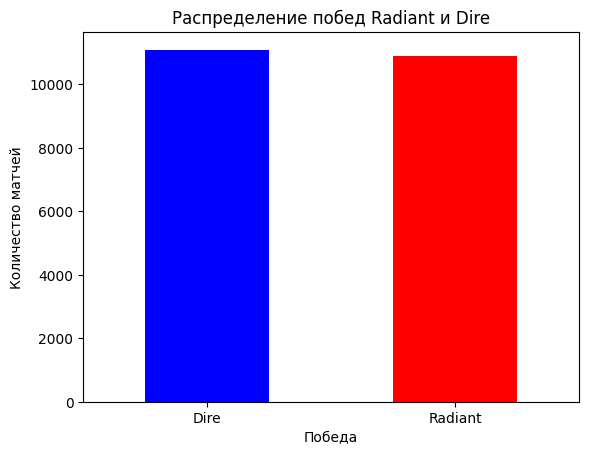

In [22]:
win_counts = match_df['radiant_win'].value_counts()
win_counts.plot(kind='bar', color=['blue', 'red'])
plt.title('Распределение побед Radiant и Dire')
plt.xlabel('Победа')
plt.ylabel('Количество матчей')
plt.xticks(ticks=[0, 1], labels=['Dire', 'Radiant'], rotation=0)
plt.show()

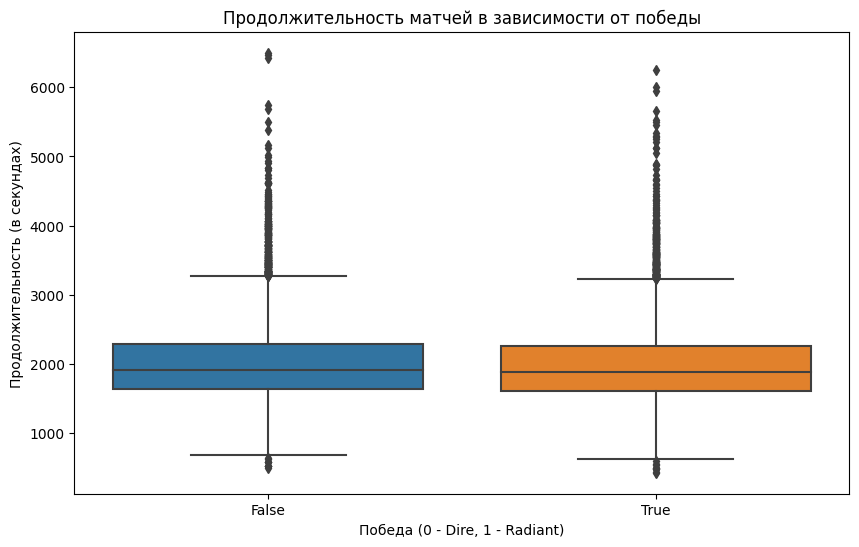

In [23]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='radiant_win', y='duration', data=match_df)
plt.title('Продолжительность матчей в зависимости от победы')
plt.xlabel('Победа (0 - Dire, 1 - Radiant)')
plt.ylabel('Продолжительность (в секундах)')
plt.show()

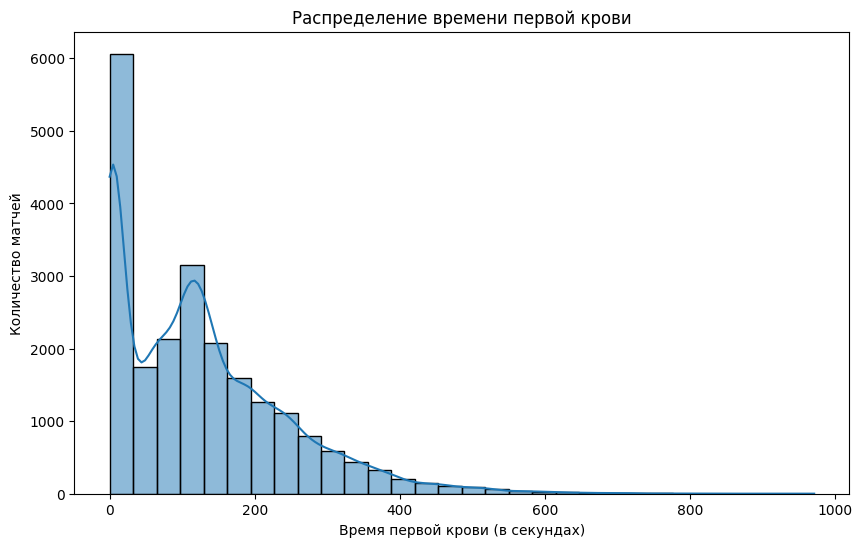

In [24]:
plt.figure(figsize=(10, 6))
sns.histplot(match_df['first_blood_time'], bins=30, kde=True)
plt.title('Распределение времени первой крови')
plt.xlabel('Время первой крови (в секундах)')
plt.ylabel('Количество матчей')
plt.show()

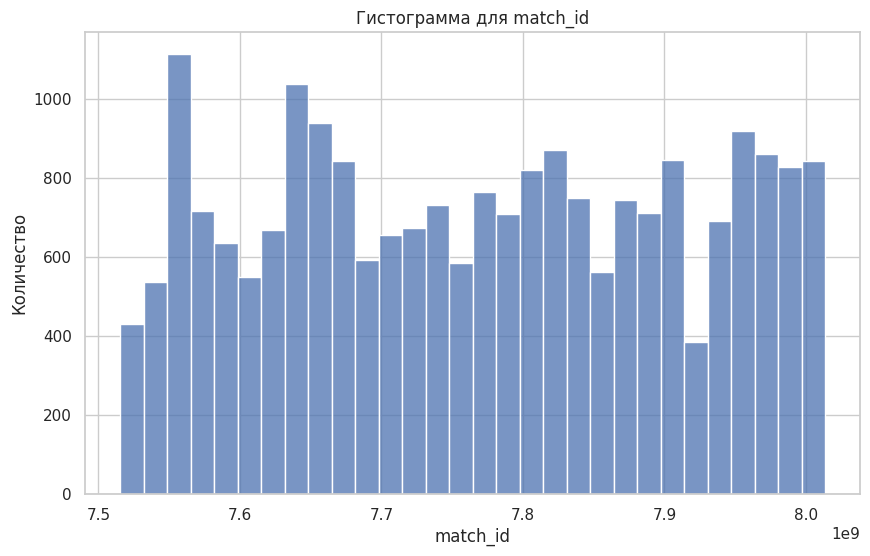

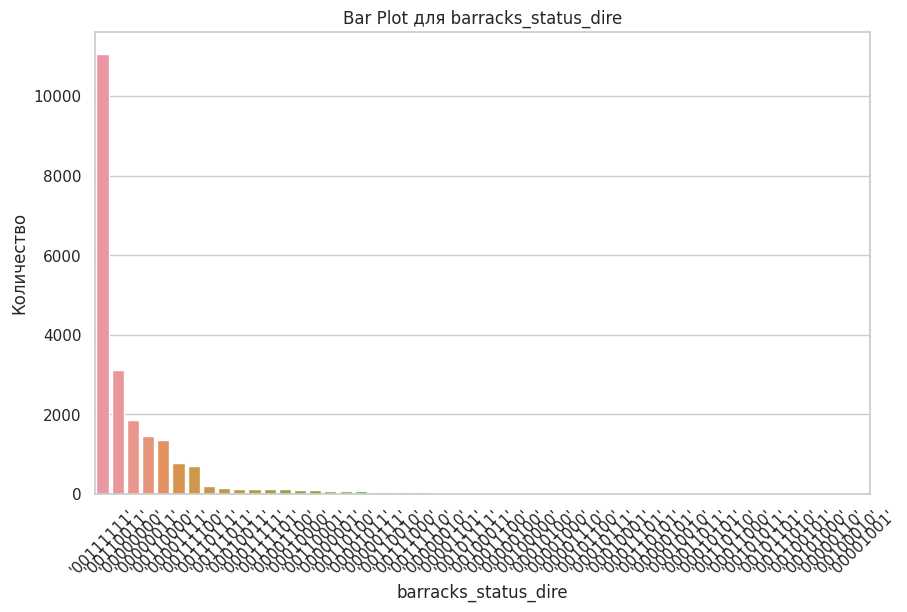

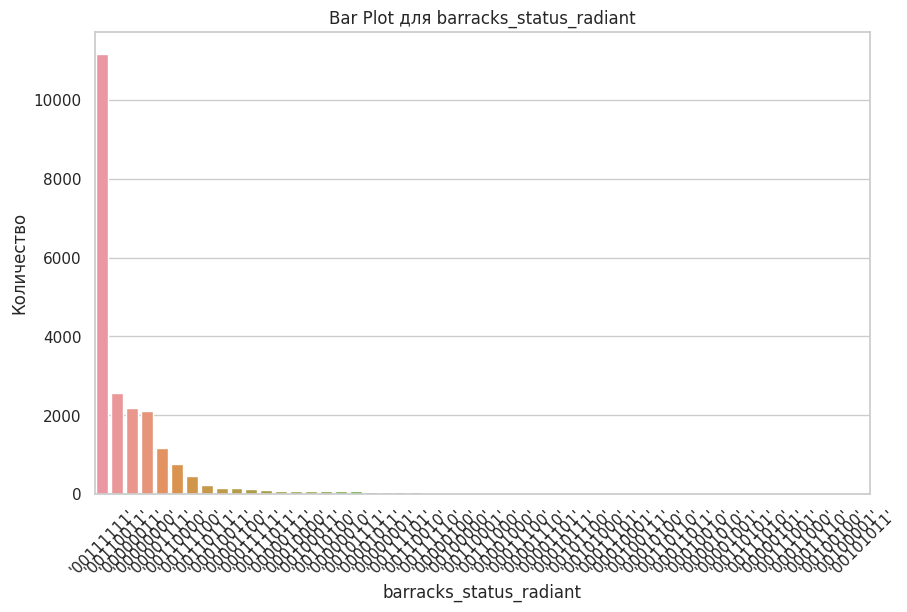

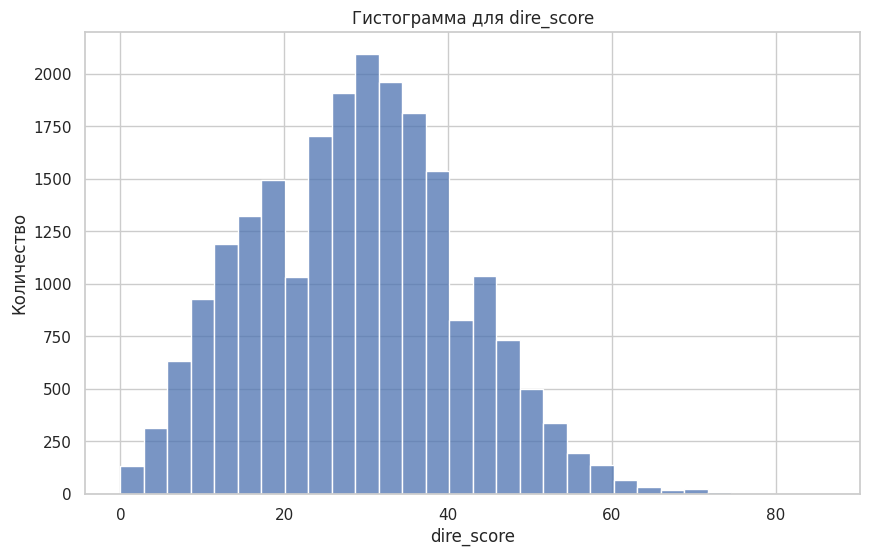

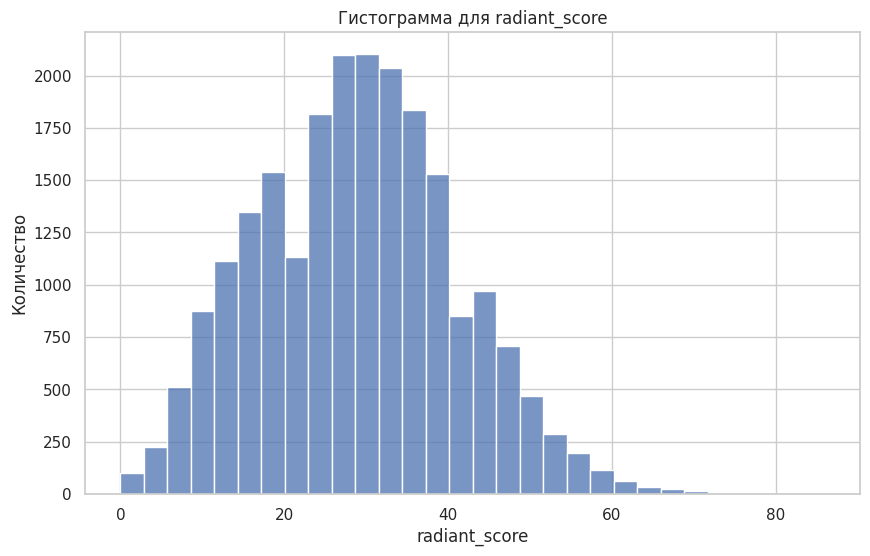

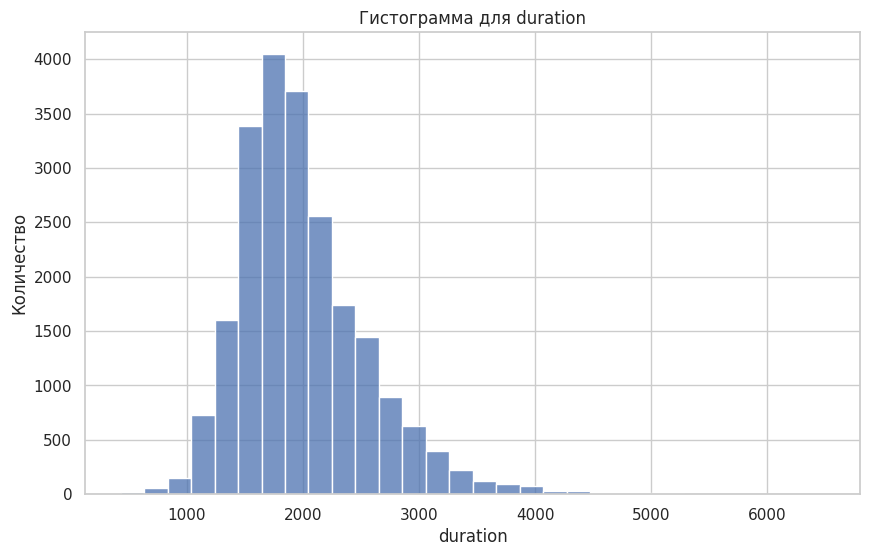

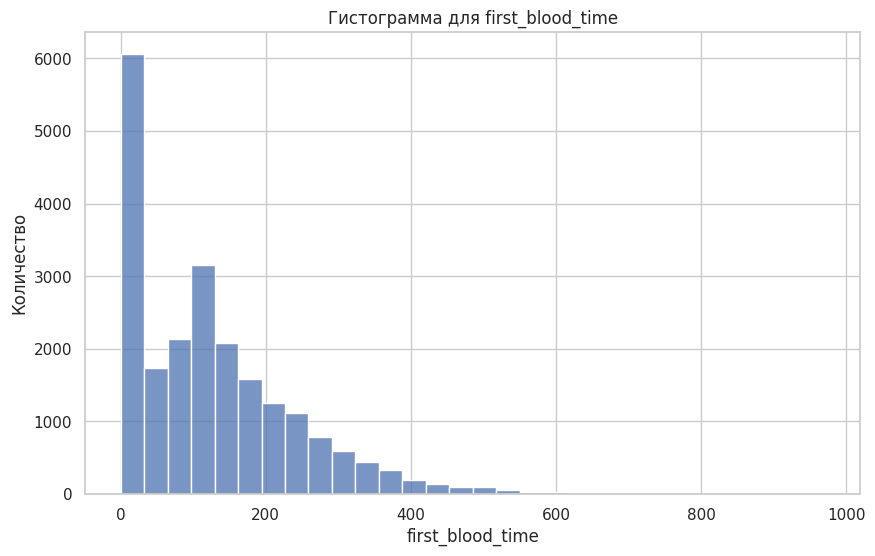

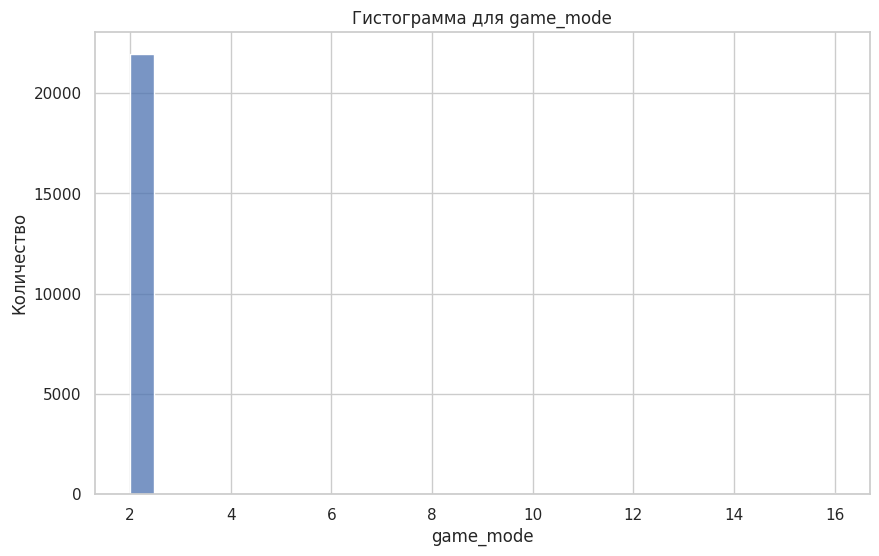

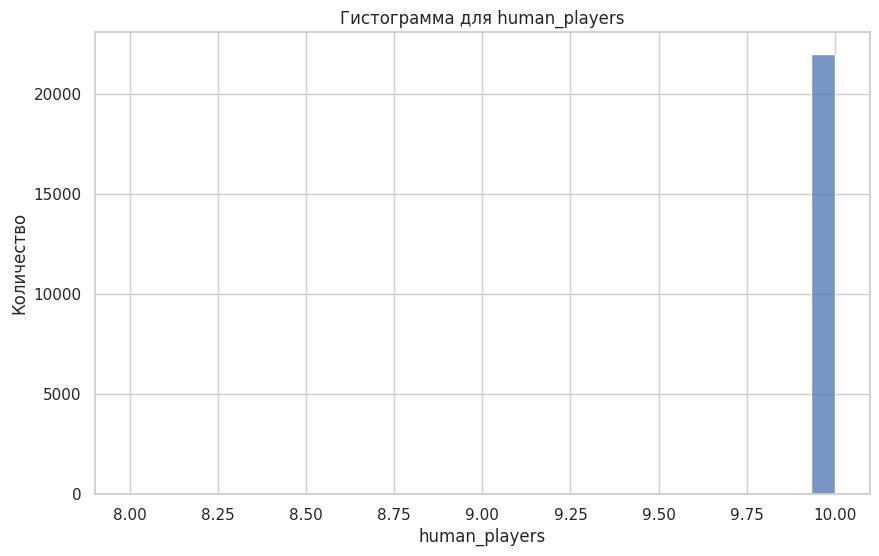

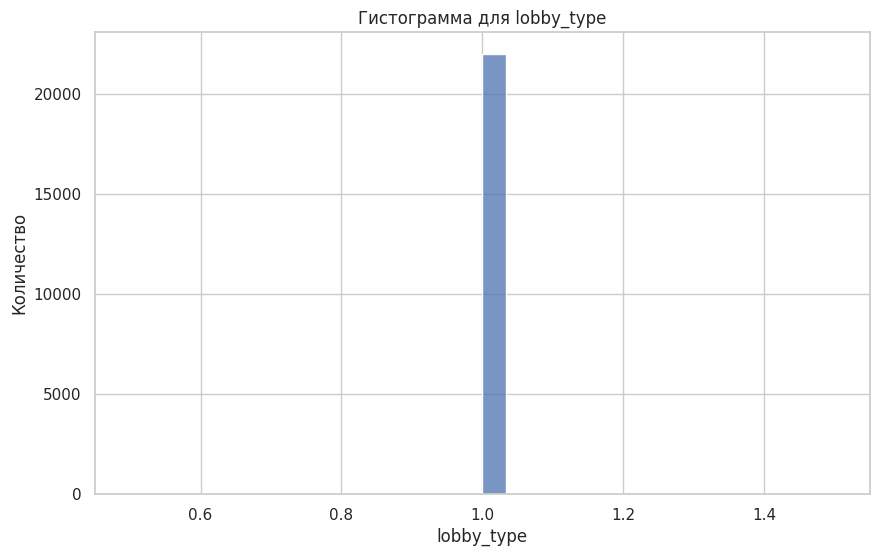

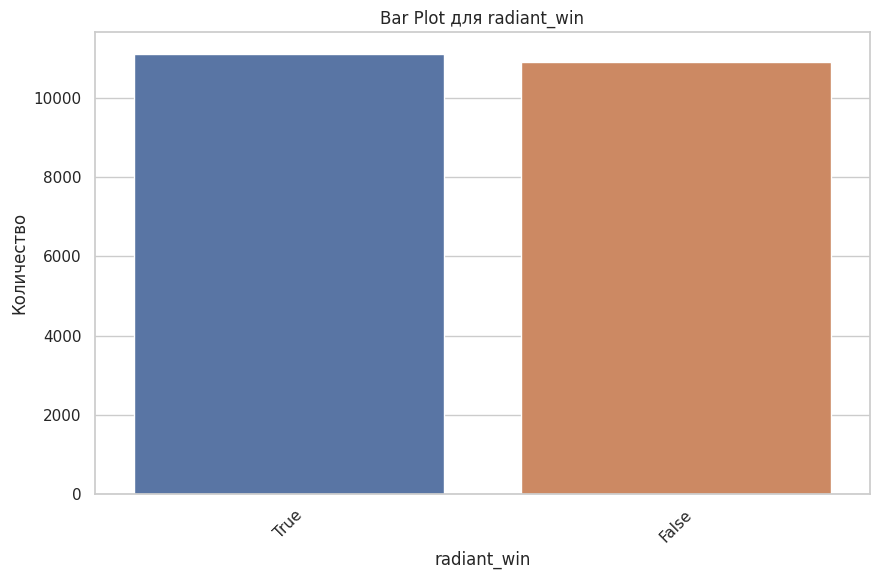

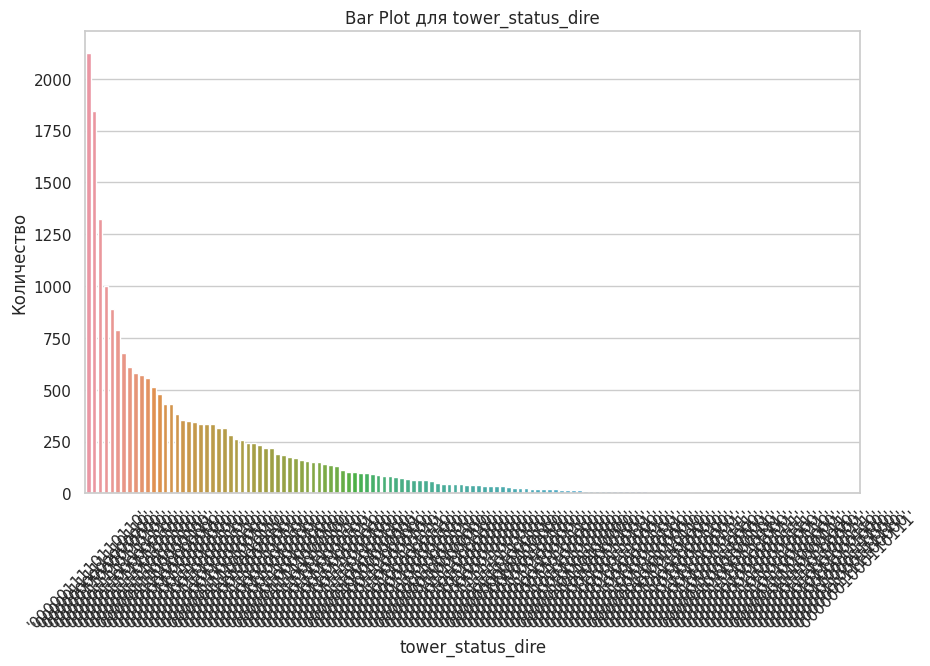

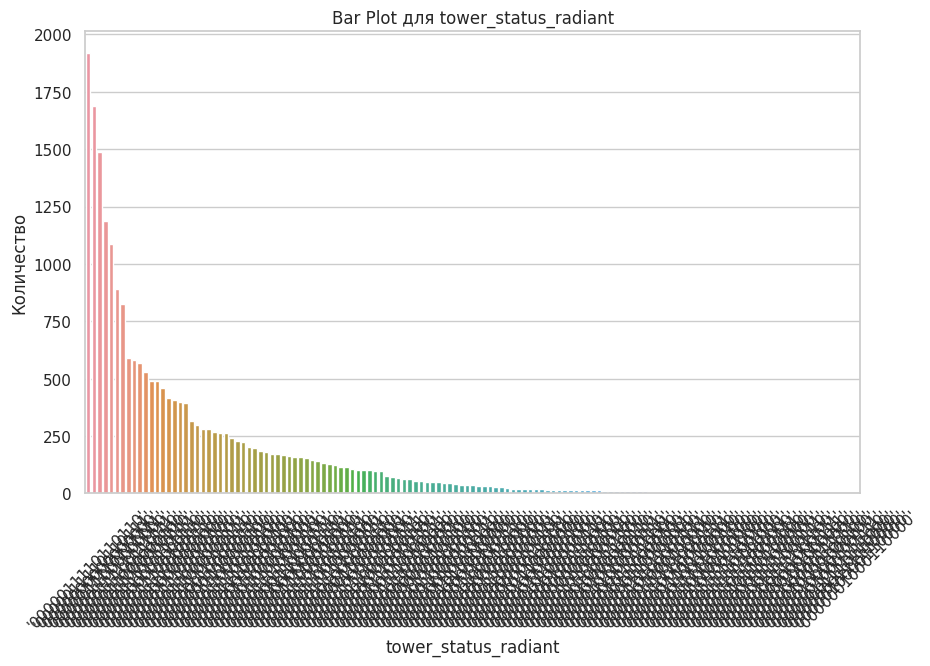

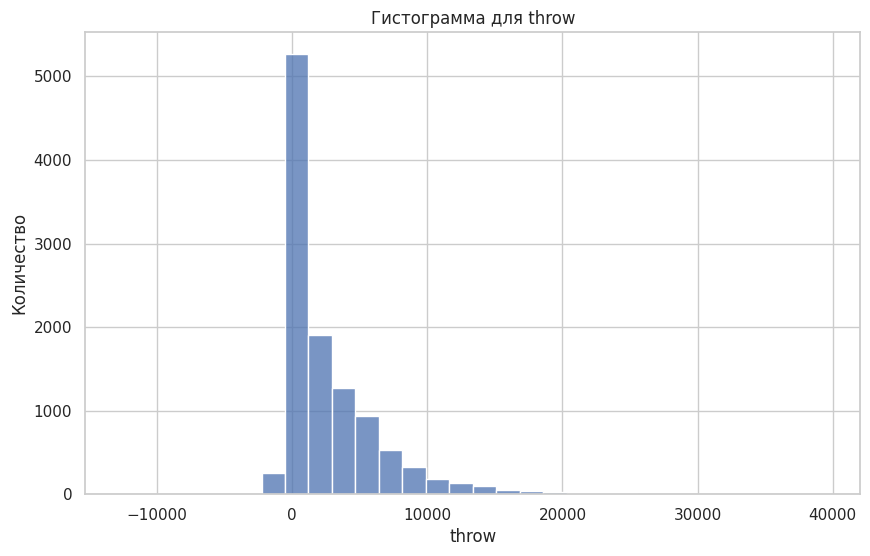

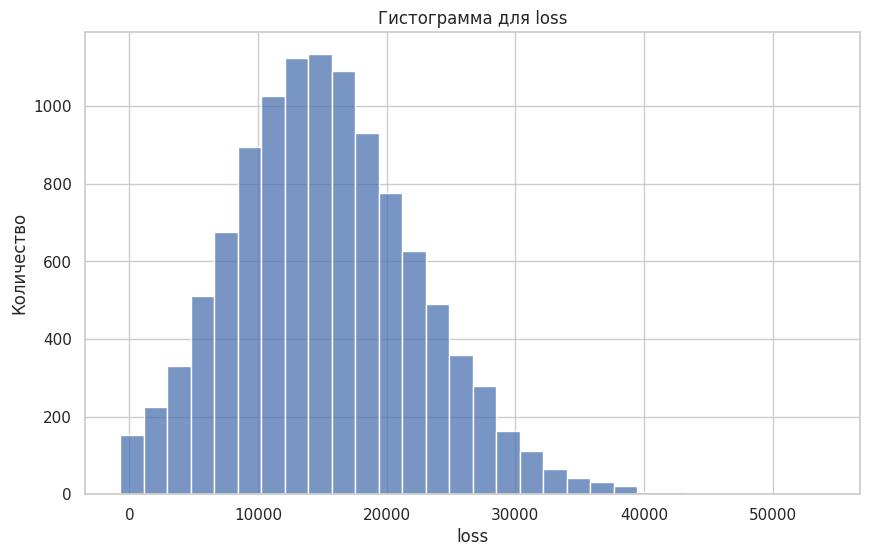

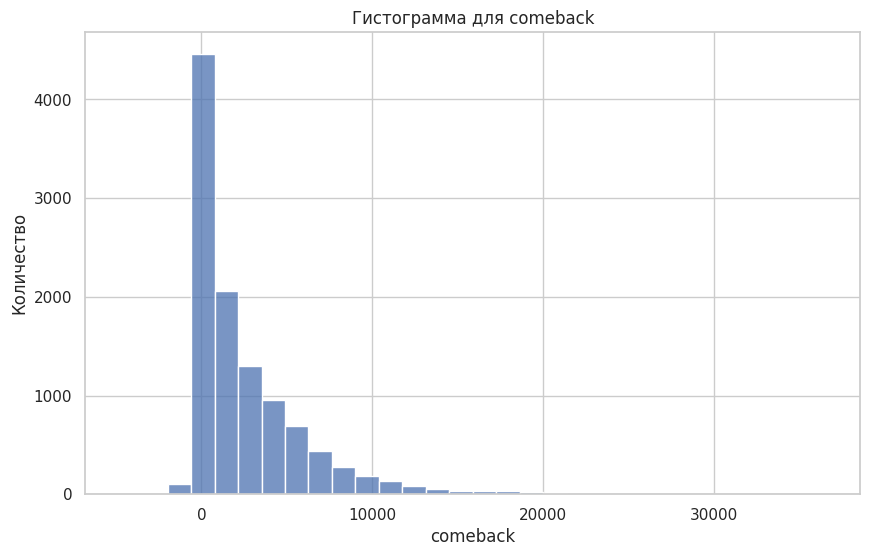

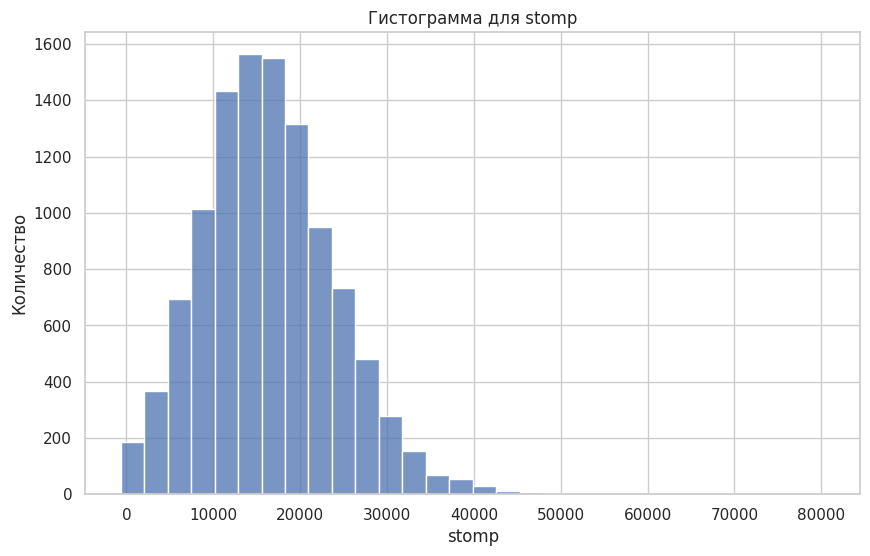

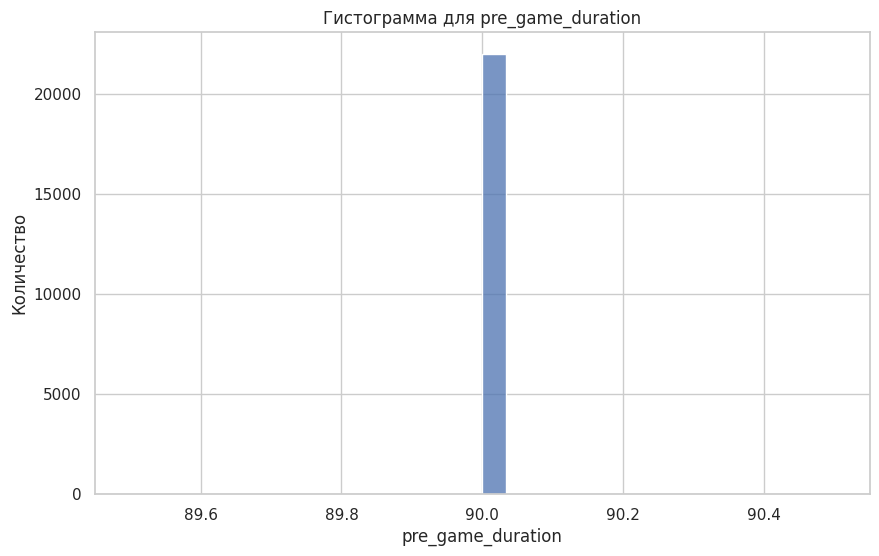

In [25]:
sns.set(style="whitegrid")

for column in match_df.columns:
    plt.figure(figsize=(10, 6))
    
    if pd.api.types.is_numeric_dtype(match_df[column]):
        sns.histplot(match_df[column], bins=30, kde=False)
        plt.title(f'Гистограмма для {column}')
        plt.xlabel(column)
        plt.ylabel('Количество')
    else:
        value_counts = match_df[column].value_counts()
        sns.barplot(x=value_counts.index.astype(str), y=value_counts.values)
        plt.title(f'Bar Plot для {column}')
        plt.xlabel(column)
        plt.ylabel('Количество')
        plt.xticks(rotation=45)
    
    plt.show()


In [26]:
match_df = match_df[match_df['game_mode'] == 2]
match_df = match_df[match_df['human_players'] == 10]
match_df = match_df[match_df['lobby_type'] == 1]

### Почистим датасет *players_df* и объединим с *match_df*

In [27]:
players_df.columns.to_list()

['match_id',
 'player_slot',
 'ability_targets',
 'ability_upgrades_arr',
 'ability_uses',
 'account_id',
 'actions',
 'additional_units',
 'assists',
 'backpack_0',
 'backpack_1',
 'backpack_2',
 'backpack_3',
 'buyback_log',
 'camps_stacked',
 'connection_log',
 'creeps_stacked',
 'damage',
 'damage_inflictor',
 'damage_inflictor_received',
 'damage_taken',
 'damage_targets',
 'deaths',
 'denies',
 'dn_t',
 'firstblood_claimed',
 'gold',
 'gold_per_min',
 'gold_reasons',
 'gold_spent',
 'gold_t',
 'hero_damage',
 'hero_healing',
 'hero_hits',
 'hero_id',
 'item_0',
 'item_1',
 'item_2',
 'item_3',
 'item_4',
 'item_5',
 'item_neutral',
 'item_uses',
 'kill_streaks',
 'killed',
 'killed_by',
 'kills',
 'kills_log',
 'lane_pos',
 'last_hits',
 'leaver_status',
 'level',
 'lh_t',
 'life_state',
 'max_hero_hit',
 'multi_kills',
 'net_worth',
 'obs',
 'obs_left_log',
 'obs_log',
 'obs_placed',
 'party_id',
 'party_size',
 'performance_others',
 'permanent_buffs',
 'pings',
 'pred_vict',
 

In [28]:
selected_columns = [
    'match_id',
    'duration',
    'game_mode',
    'start_time',
    'radiant_win',
    'hero_id',
    'player_slot',
    'kills',
    'deaths',
    'assists',
    'gold_per_min',
    'xp_per_min',
    'last_hits',
    'denies',
    'level',
    'hero_damage',
    'item_0',
    'item_1',
    'item_2',
    'item_3',
    'item_4',
    'item_5'
]

players_df = players_df[selected_columns]
players_df.head()

,match_id,duration,game_mode,start_time,radiant_win,hero_id,player_slot,kills,deaths,assists,...,last_hits,denies,level,hero_damage,item_0,item_1,item_2,item_3,item_4,item_5
0,7515635423,1926,2,1704068656,True,107.0,0,8.0,7.0,21.0,...,176.0,7.0,20.0,32753.0,116.0,119.0,92.0,127.0,36.0,29.0
1,7515635423,1926,2,1704068656,True,10.0,1,11.0,3.0,6.0,...,233.0,8.0,24.0,26629.0,36.0,75.0,1808.0,63.0,123.0,160.0
2,7515635423,1926,2,1704068656,True,79.0,2,7.0,4.0,18.0,...,118.0,4.0,17.0,13047.0,218.0,100.0,232.0,180.0,4206.0,108.0
3,7515635423,1926,2,1704068656,True,83.0,3,11.0,8.0,19.0,...,29.0,1.0,21.0,19712.0,34.0,180.0,226.0,218.0,1.0,188.0
4,7515635423,1926,2,1704068656,True,11.0,4,5.0,4.0,4.0,...,346.0,1.0,21.0,14358.0,236.0,63.0,147.0,149.0,41.0,116.0


In [29]:
players_df.describe(include='all')

,match_id,duration,game_mode,start_time,radiant_win,hero_id,player_slot,kills,deaths,assists,...,last_hits,denies,level,hero_damage,item_0,item_1,item_2,item_3,item_4,item_5
count,246515,246515,246515,246515,246508,246515,246515,246515,246515,246515,...,246515,246515,246515,246515,246515,246515,246515,246515,246515,246515
unique,24704,4242,8,24665,4,372,20,107,74,152,...,2656,167,87,91584,574,575,577,586,580,595
top,7515635423,1748,2,1720960200,True,86.0,0,2.0,5.0,8.0,...,0.0,1.0,18.0,0.0,1.0,1.0,36.0,36.0,36.0,0.0
freq,10,320,219715,30,114959,3386,22393,14235,14282,6953,...,909,15543,9649,873,10922,10550,11905,9504,10010,13577


In [30]:
players_df['radiant_win'].unique()

array(['True', 'False', nan, True, False], dtype=object)

In [31]:
players_df = players_df[players_df['radiant_win'].isin([True, False])]
players_df = players_df[players_df['game_mode'] == 2]

In [32]:
players_df.isna().sum()

match_id        0
duration        0
game_mode       0
start_time      0
radiant_win     0
hero_id         0
player_slot     0
kills           0
deaths          0
assists         0
gold_per_min    0
xp_per_min      0
last_hits       0
denies          0
level           0
hero_damage     0
item_0          0
item_1          0
item_2          0
item_3          0
item_4          0
item_5          0
dtype: int64

In [33]:
merged_df = pd.merge(match_df, players_df, on='match_id', how='inner')
merged_df.head()

,match_id,barracks_status_dire,barracks_status_radiant,dire_score,radiant_score,duration_x,first_blood_time,game_mode_x,human_players,lobby_type,...,last_hits,denies,level,hero_damage,item_0,item_1,item_2,item_3,item_4,item_5
0,7967560450,'00110011','00111111',34,35,2233,129,2,10,1,...,95,1,21,8331,1,100,40,180,21,0
1,7967560450,'00110011','00111111',34,35,2233,129,2,10,1,...,11,1,17,11850,102,206,77,36,40,180
2,7967560450,'00110011','00111111',34,35,2233,129,2,10,1,...,259,6,24,20036,50,1,116,108,235,119
3,7967560450,'00110011','00111111',34,35,2233,129,2,10,1,...,417,0,27,30281,48,96,203,176,235,244
4,7967560450,'00110011','00111111',34,35,2233,129,2,10,1,...,446,5,28,42770,603,156,50,116,208,145


In [34]:
merged_df.columns

Index(['match_id', 'barracks_status_dire', 'barracks_status_radiant',
       'dire_score', 'radiant_score', 'duration_x', 'first_blood_time',
       'game_mode_x', 'human_players', 'lobby_type', 'radiant_win_x',
       'tower_status_dire', 'tower_status_radiant', 'throw', 'loss',
       'comeback', 'stomp', 'pre_game_duration', 'duration_y', 'game_mode_y',
       'start_time', 'radiant_win_y', 'hero_id', 'player_slot', 'kills',
       'deaths', 'assists', 'gold_per_min', 'xp_per_min', 'last_hits',
       'denies', 'level', 'hero_damage', 'item_0', 'item_1', 'item_2',
       'item_3', 'item_4', 'item_5'],
      dtype='object')

# Описание полей в Dota 2 датасете

| Поле                        | Тип       | Описание                                                                                  |
|-----------------------------|-----------|-------------------------------------------------------------------------------------------|
| `match_id`                  | Integer   | Уникальный идентификатор матча.                                                           |
| `barracks_status_dire`      | Integer   | Состояние бараков команды Dire (0 - все живые, 1 - один разрушен, 2 - оба разрушены).   |
| `barracks_status_radiant`   | Integer   | Состояние бараков команды Radiant (0 - все живые, 1 - один разрушен, 2 - оба разрушены).|
| `dire_score`                | Integer   | Очки команды Dire по окончании матча.                                                    |
| `radiant_score`             | Integer   | Очки команды Radiant по окончании матча.                                                |
| `duration_x`                | Integer   | Продолжительность матча в секундах (версия X).                                          |
| `first_blood_time`          | Integer   | Время, когда произошло первое убийство (в секундах).                                     |
| `game_mode_x`               | Integer   | Режим игры (например, 1 для "All Pick", 2 для "Captain's Mode" и т.д., версия X).     |
| `human_players`             | Integer   | Общее количество игроков-людей в игре.                                                   |
| `lobby_type`                | Integer   | Тип лобби (например, 0 для обычного, 1 для рейтингового и т.д.).                       |
| `radiant_win_x`             | Boolean   | Указывает, выиграла ли команда Radiant в версии X (True или False).                     |
| `tower_status_dire`         | Integer   | Состояние башен команды Dire (0 - все живые, 1 - одна разрушена, 2 - две разрушены и т.д.). |
| `tower_status_radiant`      | Integer   | Состояние башен команды Radiant (0 - все живые, 1 - одна разрушена, 2 - две разрушены и т.д.). |
| `throw`                     | Boolean   | Указывает, произошла ли "потеря" преимущества.                                           |
| `loss`                      | Boolean   | Указывает, проиграла ли команда (True - проиграла, False - выиграла).                   |
| `comeback`                  | Boolean   | Указывает, произошло ли "возвращение" команды после отставания.                         |
| `stomp`                     | Boolean   | Указывает, был ли матч "накатанным" (одна команда доминировала).                        |
| `pre_game_duration`         | Integer   | Продолжительность подготовки перед матчем в секундах.                                    |
| `duration_y`                | Integer   | Продолжительность матча в секундах (версия Y).                                          |
| `game_mode_y`               | Integer   | Режим игры (версия Y).                                                                    |
| `start_time`                | Integer   | Время начала матча в формате UNIX timestamp.                                             |
| `radiant_win_y`             | Boolean   | Указывает, выиграла ли команда Radiant в версии Y (True или False).                     |
| `hero_id`                   | Integer   | Уникальный идентификатор героя, выбранного игроком.                                     |
| `player_slot`               | Integer   | Номер слота игрока (0-4 для Radiant и 128-132 для Dire).                               |
| `kills`                     | Integer   | Общее количество убийств, совершенных игроком в матче.                                   |
| `deaths`                    | Integer   | Общее количество смертей игрока в матче.                                                 |
| `assists`                   | Integer   | Общее количество помощей, оказанных игроком в матче.                                     |кретной задачи.
